In [1]:
import time
import os
import torch
import torch.nn as nn
import numpy as np

from torch.optim import LBFGS, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.parameter import Parameter
from tqdm import tqdm


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec


torch.set_default_dtype(torch.float64)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype  = torch.float64

In [2]:
class ConventBlock(nn.Module):
    def __init__(self,in_N,out_N):
        super(ConventBlock, self).__init__()
        self.Ls  = None
        self.net =nn.Sequential(nn.Linear(in_N,out_N),nn.Tanh()) 

    def forward(self, x):
        out = self.net(x)
        return out 

In [3]:
class Network(torch.nn.Module):
    def __init__(self,layers,**kwargs):
        super(Network,self).__init__()
        self.mu    = kwargs["mean"]
        self.stdev = kwargs["stdev"]
            
        _layers = [] 
        for i in range(0,len(layers)-2):
            _layers.append(ConventBlock(layers[i],layers[i+1]))
            
        _layers.append(torch.nn.Linear(layers[-2],layers[-1]))
        self.net = torch.nn.Sequential(*_layers)
        
    def forward(self,x,y):
        data = torch.cat((x,y),dim=1);
        # normalize the input
        data = (data - self.mu)/self.stdev
        out  = self.net(data)
        return out
        
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.zeros_(m.bias)

In [4]:
# ----------------------------------------------
#  Defining the rhs : u_xx + u_yy + u = RHS(x,y)
# ----------------------------------------------
def u_exact(x,y):
    return torch.sin(np.pi*x)*torch.sin(4.0*np.pi*y) 

def u_xx(x,y):
    return -(np.pi)**2 * u_exact(x,y)

def u_yy(x,y):
    return -(4.0*np.pi)**2 * u_exact(x,y)

def RHS(x,y):
    result = u_xx(x,y) + u_yy(x,y) + u_exact(x,y)
    return result


In [5]:
def fetch_interior_points(domain,batch_size):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """
    dim = domain.shape[0]
    soboleng = torch.quasirandom.SobolEngine(dimension=dim,scramble=True)
    data     = soboleng.draw(batch_size,dtype=dtype)*(domain[1] - domain[0]) + domain[0]
    x       = data[:,0][:,None]
    y       = data[:,1][:,None]
    return x,y

In [6]:
def fetch_boundary_points(domain,batch_size):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """
    x_min    = domain[0][0]
    x_max    = domain[1][0]
    
    y_min    = domain[0][1]
    y_max    = domain[1][1]
    
    dim      = domain.shape[0]
    
    x,y      =  fetch_interior_points(domain,batch_size)
    
    E_bc = torch.cat(( torch.ones_like(x),     y), dim = 1)
    W_bc = torch.cat(( torch.full_like(x,x_min),y), dim = 1)

    N_bc = torch.cat((x, torch.ones_like(y)     ), dim = 1)   
    S_bc = torch.cat((x, torch.full_like(y,y_min)), dim = 1)
    
    data   = torch.cat((N_bc, S_bc, E_bc, W_bc), dim = 0)
    
    x      = data[:,0][:,None]
    y      = data[:,1][:,None]
    return x,y

In [7]:
def PDE_OPT(model,x,y):
    u       = model(x,y)
    u_x,u_y = torch.autograd.grad(u.sum(),(x,y),create_graph=True)
    u_xx    = torch.autograd.grad(u_x.sum(),x,create_graph=True)[0]
    u_yy    = torch.autograd.grad(u_y.sum(),y,create_graph=True)[0]
    loss    = (u_xx + u_yy + u - RHS(x,y)).pow(2).sum()
    return loss

In [8]:
def BC_OPT(model,x_bc,y_bc,u_bc):
    u       = model(x_bc,y_bc)
    loss    = (u - u_bc).pow(2)
    return loss

In [9]:
def evaluate(model,domain):
    model.eval()
    x = np.linspace(domain[0][0],domain[1][0],64)
    t = np.linspace(domain[0][1],domain[1][1],64)

    x_star,t_star = np.meshgrid(x,t)
    x_test = torch.from_numpy(x_star.flatten()[:,None])
    t_test = torch.from_numpy(t_star.flatten()[:,None])

    u_star = u_exact(x_test,t_test)   
    u_pred = model(x_test,t_test)
    
    l2   = np.linalg.norm(u_star- u_pred.detach(), 2)/np.linalg.norm(u_star, 2)
    linf = max(abs(u_star- u_pred.detach().numpy())).item()
    return l2,linf

# creating the neural network model

In [10]:
domain   = np.array([[-1,-1.0],[1.,1.]])
kwargs ={"mean":torch.tensor([[0.0, 0.0]]), "stdev":torch.tensor([[0.5773, 0.5773]])}   
layers = [2,30,30,30,1]
model  = Network(layers,**kwargs)
model.apply(init_weights)
print(model)
print(model.mu.shape)
print(model.stdev.shape)

Network(
  (net): Sequential(
    (0): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=30, bias=True)
        (1): Tanh()
      )
    )
    (1): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=30, out_features=30, bias=True)
        (1): Tanh()
      )
    )
    (2): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=30, out_features=30, bias=True)
        (1): Tanh()
      )
    )
    (3): Linear(in_features=30, out_features=1, bias=True)
  )
)
torch.Size([1, 2])
torch.Size([1, 2])


# generating collocation points (x,y)

In [11]:
# number of collocation points in the domain
batch_size   = 500
x_dm,y_dm    = fetch_interior_points(domain,batch_size)
x_dm         = x_dm.requires_grad_(True)
y_dm         = y_dm.requires_grad_(True)

# generating boundary data (x,y) -> u(x,y)

In [12]:
batch_size   = 64 # per boundary face
x_bc,y_bc    = fetch_boundary_points(domain,batch_size)
u_bc         = u_exact(x_bc,y_bc)

# choosing the optimizer 

In [13]:
optimizer = LBFGS(model.parameters(),line_search_fn="strong_wolfe")

# initializing the Lagrange multipliers

In [14]:
lambda_bc    = torch.ones_like(x_bc)
v_bc         = torch.zeros_like(x_bc)

beta         = 0.9
eta          = 1.0
print('beta:',beta)

beta: 0.9


# number of epochs

In [15]:
epochs = 5000

In [16]:
linf_norms      = []
l2_norms        = []
trials          = 10
for trial in range(1,trials+1): 
    # TODO : initialize the model at each itertion
    model.apply(init_weights)
    
    print("*"*20 + f' run({trial}) '+"*"*20)
    for epoch in range(1,epochs+1): 

        def closure():
            if torch.is_grad_enabled():
                optimizer.zero_grad()

            physics_loss    = PDE_OPT(model,x_dm,y_dm)
            boundary_res    = BC_OPT(model,x_bc,y_bc,u_bc)
            boundary_loss   = (lambda_bc * boundary_res).sum()

            loss            = physics_loss +  boundary_loss
            if loss.requires_grad:
                loss.backward()
            return loss

        def _closure():
            boundary_res = BC_OPT(model,x_bc,y_bc,u_bc)
            return boundary_res

        # TODO: updating the parameters
        optimizer.step(closure)

        # TODO: gradient of lagrange multipliers
        boundary_res = _closure()

        # TODO: updating the lagrange multipliers 
        with torch.no_grad():
            v_bc        = (1.0 - beta) * boundary_res.pow(2) + beta * v_bc
            lambda_bc  += eta/(v_bc + 1e-8).sqrt() * boundary_res

        if epoch % 1000 == 0:  
            u_l2,u_linf = evaluate(model,domain)
            print(f"epoch : {epoch:5d},u l2 :{u_l2:2.3e}, u linf : {u_linf :2.3e}")      
    # evaluate 
    l2,linf = evaluate(model,domain)
    l2_norms.append(l2)
    linf_norms.append(linf)
    torch.save(model.state_dict(),f"models/Helmholtz_{trial}.pt")

******************** run(1) ********************
epoch :  1000,u l2 :4.617e-04, u linf : 2.418e-03
epoch :  2000,u l2 :3.277e-04, u linf : 1.542e-03
epoch :  3000,u l2 :2.654e-04, u linf : 1.622e-03
epoch :  4000,u l2 :2.029e-04, u linf : 1.165e-03
epoch :  5000,u l2 :1.805e-04, u linf : 1.010e-03
******************** run(2) ********************
epoch :  1000,u l2 :7.425e-04, u linf : 2.867e-03
epoch :  2000,u l2 :4.294e-04, u linf : 1.299e-03
epoch :  3000,u l2 :3.600e-04, u linf : 1.123e-03
epoch :  4000,u l2 :2.992e-04, u linf : 9.456e-04
epoch :  5000,u l2 :2.334e-04, u linf : 7.669e-04
******************** run(3) ********************
epoch :  1000,u l2 :5.913e-04, u linf : 1.815e-03
epoch :  2000,u l2 :7.698e-04, u linf : 1.712e-03
epoch :  3000,u l2 :5.373e-04, u linf : 1.684e-03
epoch :  4000,u l2 :4.209e-04, u linf : 1.285e-03
epoch :  5000,u l2 :3.104e-04, u linf : 9.184e-04
******************** run(4) ********************
epoch :  1000,u l2 :5.891e-04, u linf : 2.156e-03
epoc

In [17]:
# New Results 
print('mean L_2: %2.2e' % np.mean(l2_norms))
print('std  L_2: %2.2e' % np.std(l2_norms))
print('*'*20)

print('mean L_inf: %2.2e' % np.mean(linf_norms))
print('std  L_inf: %2.2e' % np.std(linf_norms))
print("*"*20)
print('total trials: ',len(linf_norms))

mean L_2: 2.77e-04
std  L_2: 9.15e-05
********************
mean L_inf: 9.04e-04
std  L_inf: 3.77e-04
********************
total trials:  10


# testing 

In [15]:
trial = 9
PATH  = os.getcwd() + f"/models/Helmholtz_{trial}.pt"
model.load_state_dict(torch.load(PATH))
model.eval()

Network(
  (net): Sequential(
    (0): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=30, bias=True)
        (1): Tanh()
      )
    )
    (1): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=30, out_features=30, bias=True)
        (1): Tanh()
      )
    )
    (2): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=30, out_features=30, bias=True)
        (1): Tanh()
      )
    )
    (3): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [16]:
xstar = np.linspace(domain[0][0],domain[1][0],100)
ystar = np.linspace(domain[0][1],domain[1][1],100)

x_star,y_star = np.meshgrid(xstar,ystar)
x_test = torch.from_numpy(x_star.flatten()[:,None])
y_test = torch.from_numpy(y_star.flatten()[:,None])
u_star  = u_exact(x_test,y_test).reshape(x_star.shape).numpy()
u_pred  = model(x_test,y_test).detach().reshape(x_star.shape).numpy()

In [23]:
# https://joseph-long.com/writing/colorbars/
def colorbar(mappable,min_val,max_val,limit):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    ticks = np.linspace(min_val, max_val, 4, endpoint=True)
    cbar = fig.colorbar(mappable, cax=cax,ticks=ticks)
    cbar.formatter.set_powerlimits((limit, limit))
    plt.sca(last_axes)
    return cbar

params = {
    'text.latex.preamble': '\\usepackage{gensymb}',
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels
    'axes.titlesize': 24,
    'font.size'     : 20, 
    'legend.fontsize': 18, 
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex': False,
    'figure.figsize': [3, 3],
    'font.family': 'serif',
}
plt.rcParams.update(params)
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cmap = plt.cm.get_cmap(cmap_list[8]).reversed()

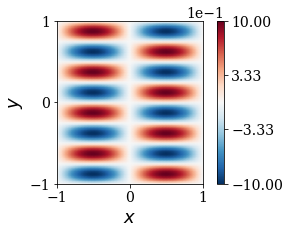

In [24]:
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])
img=ax.pcolormesh(x_star,y_star,u_pred,cmap=cmap,shading='gouraud')
cbar = colorbar(img,min_val=np.amin(u_pred),max_val=np.amax(u_pred),limit=-1)
ax.set_yticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_xticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
filename="figures/helmholtz_prediction"
plt.savefig('{}.png'.format(filename), bbox_inches='tight', pad_inches=0.02)
plt.show()

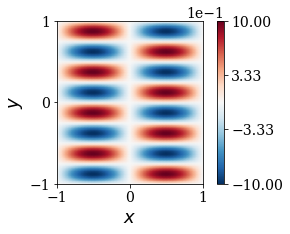

In [25]:
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])
img=ax.pcolormesh(x_star,y_star,u_star,shading='gouraud',cmap=cmap)
cbar = colorbar(img,min_val=np.amin(u_star),max_val=np.amax(u_star),limit=-1)
ax.set_yticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_xticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
filename="figures/helmholtz_exact"
plt.savefig('{}.png'.format(filename), bbox_inches='tight', pad_inches=0.02)
plt.show()

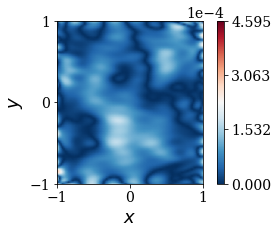

In [27]:
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])

error = np.abs(u_star - u_pred)
max_val= np.amin(error)
min_val= np.amax(error)
img=ax.pcolormesh(x_star,y_star,error,shading='gouraud',cmap=cmap)
ax.set_xticks([0,0.5,1])
ax.set_yticks([0,0.5,1])
cbar = colorbar(img,min_val,max_val,limit=0)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_yticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_xticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])
filename="figures/helmholtz_absolute_error"
plt.savefig('{}.png'.format(filename), bbox_inches='tight', pad_inches=0.02)
plt.show()